In [81]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fetch DAX data
dax = yf.Ticker('DAX').history(period='2y')
data = dax[['Close']].reset_index()

# Basic preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

TEST_DAYS = 30


### ARIMA

In [1]:
%pip install pmdarima "numpy<2"

In [82]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Train-test split
train_size = int(len(data) - TEST_DAYS)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Auto ARIMA for parameter selection
model_arima = auto_arima(train, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)
print(f"Best ARIMA params: {model_arima.order}")

# Fit model
arima = ARIMA(train, order=(3,1,2))
arima_fit = arima.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=186.514, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=179.960, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=181.941, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=181.942, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=180.830, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=183.478, Time=1.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.946 seconds
Best ARIMA params: (0, 1, 0)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

### Prophet

In [85]:
from prophet import Prophet


prophet_train_data = train.reset_index()[['Date', 'Close']].rename(
    columns={'Date': 'ds', 'Close': 'y'})
prophet_train_data['ds'] = prophet_train_data['ds'].dt.tz_localize(None)

# Model configuration
m = Prophet(
    yearly_seasonality=True,
)
m.add_country_holidays(country_name='DE')
m.fit(prophet_train_data)

# Create future dataframe
future = m.make_future_dataframe(periods=len(test))
prophet_forecast = m.predict(future)[-len(test):]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi5z_kyrs/qlmvg8z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi5z_kyrs/lv51r3oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59706', 'data', 'file=/tmp/tmpi5z_kyrs/qlmvg8z5.json', 'init=/tmp/tmpi5z_kyrs/lv51r3oa.json', 'output', 'file=/tmp/tmpi5z_kyrs/prophet_modelfmfp2fcz/prophet_model-20250401211701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


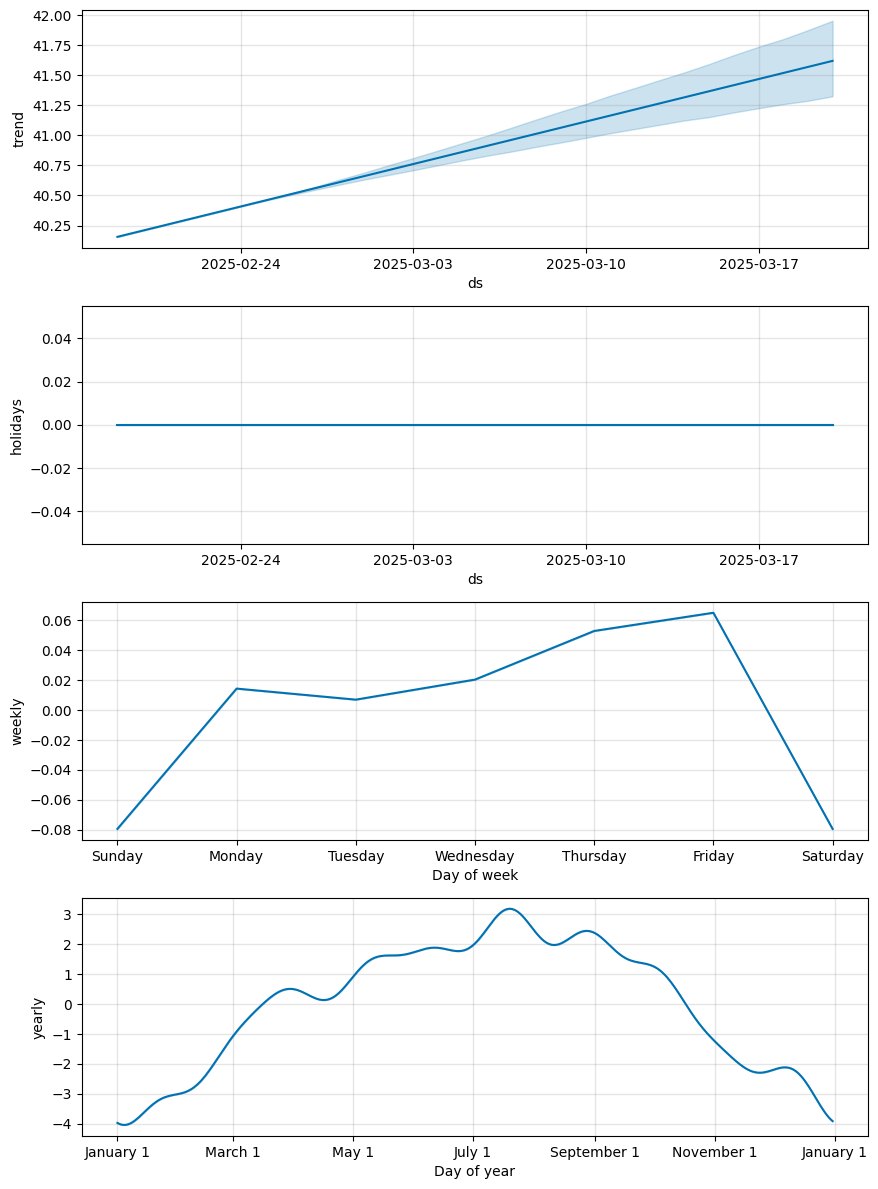

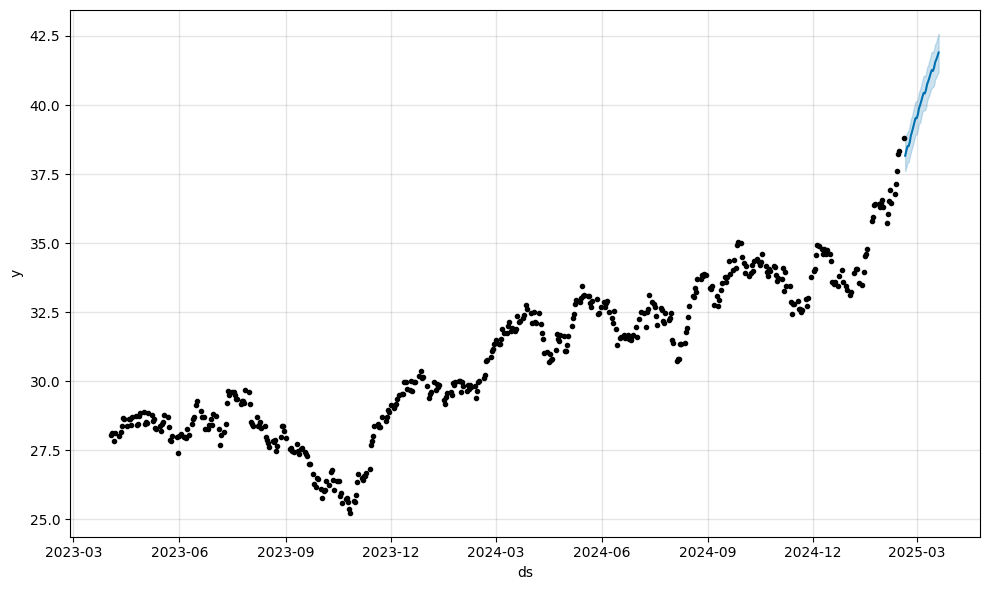

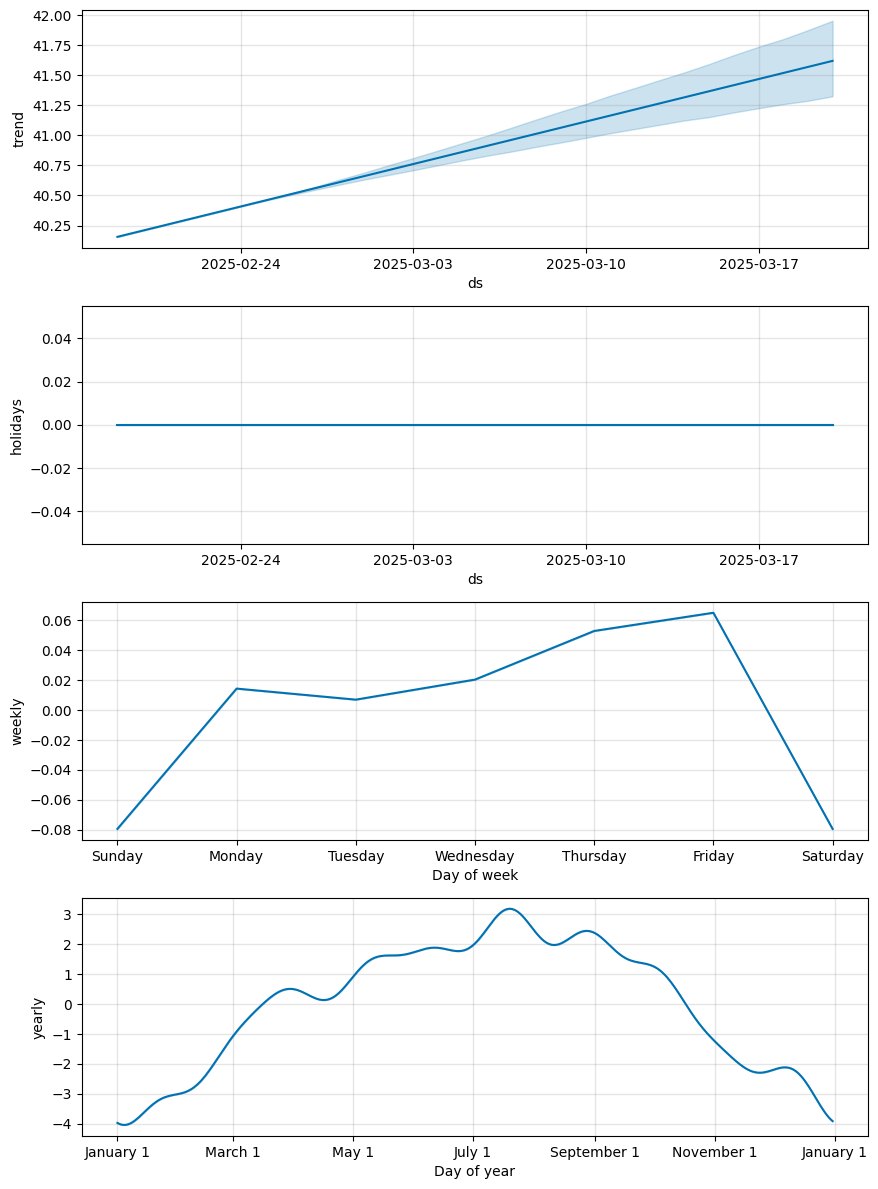

In [86]:
m.plot(prophet_forecast)
m.plot_components(prophet_forecast)

In [87]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from sklearn.preprocessing import MinMaxScaler


class DAXDataset(Dataset):
    def __init__(self, data, sequence_length=60):
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_data = self.scaler.fit_transform(data)
        self.X, self.y = self.create_sequences()

    def create_sequences(self):
        X, y = [], []
        for i in range(len(self.scaled_data)-self.sequence_length-1):
            X.append(self.scaled_data[i:i+self.sequence_length])
            y.append(self.scaled_data[i+self.sequence_length])
        return torch.FloatTensor(X), torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class DAXLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(DAXLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM layers with dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)

        # Final dense layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # First LSTM layer
        out, (h_n, c_n) = self.lstm1(x)
        out = self.dropout1(out)

        # Second LSTM layer
        out, (h_n, c_n) = self.lstm2(out)
        out = self.dropout2(out)

        # Get last time step's output
        out = out[:, -1, :]
        out = self.linear(out)
        return out


def train_model(model, dataset: DAXDataset, epochs=100, batch_size=32):
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset = Subset(dataset, range(0, train_size))
    val_dataset = Subset(dataset, range(train_size, len(dataset)))

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Training components
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val).item()

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}')

    return model


In [88]:
data_for_lstm = train['Close'].values.reshape(-1, 1)
lstm_dataset = DAXDataset(data_for_lstm, sequence_length=60)

In [89]:
model = DAXLSTM(input_size=1, hidden_size=60, output_size=1)
trained_model = train_model(model, lstm_dataset, epochs=30)

Epoch 1/30 | Train Loss: 0.2019 | Val Loss: 0.3300
Epoch 2/30 | Train Loss: 0.0131 | Val Loss: 0.0177
Epoch 3/30 | Train Loss: 0.1012 | Val Loss: 0.1545
Epoch 4/30 | Train Loss: 0.0429 | Val Loss: 0.1451
Epoch 5/30 | Train Loss: 0.0252 | Val Loss: 0.0723
Epoch 6/30 | Train Loss: 0.0269 | Val Loss: 0.0515
Epoch 7/30 | Train Loss: 0.0338 | Val Loss: 0.0656
Epoch 8/30 | Train Loss: 0.0270 | Val Loss: 0.0581
Epoch 9/30 | Train Loss: 0.0219 | Val Loss: 0.0408
Epoch 10/30 | Train Loss: 0.0216 | Val Loss: 0.0275
Epoch 11/30 | Train Loss: 0.0153 | Val Loss: 0.0049
Epoch 12/30 | Train Loss: 0.0115 | Val Loss: 0.0076
Epoch 13/30 | Train Loss: 0.0110 | Val Loss: 0.0073
Epoch 14/30 | Train Loss: 0.0074 | Val Loss: 0.0121
Epoch 15/30 | Train Loss: 0.0103 | Val Loss: 0.0043
Epoch 16/30 | Train Loss: 0.0105 | Val Loss: 0.0076
Epoch 17/30 | Train Loss: 0.0077 | Val Loss: 0.0064
Epoch 18/30 | Train Loss: 0.0081 | Val Loss: 0.0074
Epoch 19/30 | Train Loss: 0.0105 | Val Loss: 0.0070
Epoch 20/30 | Train L

In [90]:
# Make predictions
test_data_for_lstm = pd.concat([train[-60-1:], test])['Close'].values.reshape(-1, 1)
test_lstm_dataset = DAXDataset(test_data_for_lstm, sequence_length=60)
test_loader = DataLoader(test_lstm_dataset, batch_size=32)

In [98]:
test.shape, test_data_for_lstm.shape, len(test_lstm_dataset)

((30, 1), (91, 1), 30)

In [92]:
predictions = []
with torch.no_grad():
    for X, _ in test_loader:
        preds = trained_model(X).cpu().numpy()
        predictions.extend(preds.squeeze())

# Inverse transform predictions
scaled_predictions = np.array(predictions).reshape(-1, 1)
lstm_forecast = test_lstm_dataset.scaler.inverse_transform(scaled_predictions)

In [96]:
models = {
    'ARIMA': arima_forecast,
    'Prophet': prophet_forecast['yhat'].values,
    'LSTM': lstm_forecast.flatten()
}

results = pd.DataFrame(index=test.index)
for name, pred in models.items():
    results[f'{name}_Pred'] = pred
    results[f'{name}_RMSE'] = np.sqrt(mean_squared_error(test['Close'], pred))
    results[f'{name}_MAE'] = mean_absolute_error(test['Close'], pred)


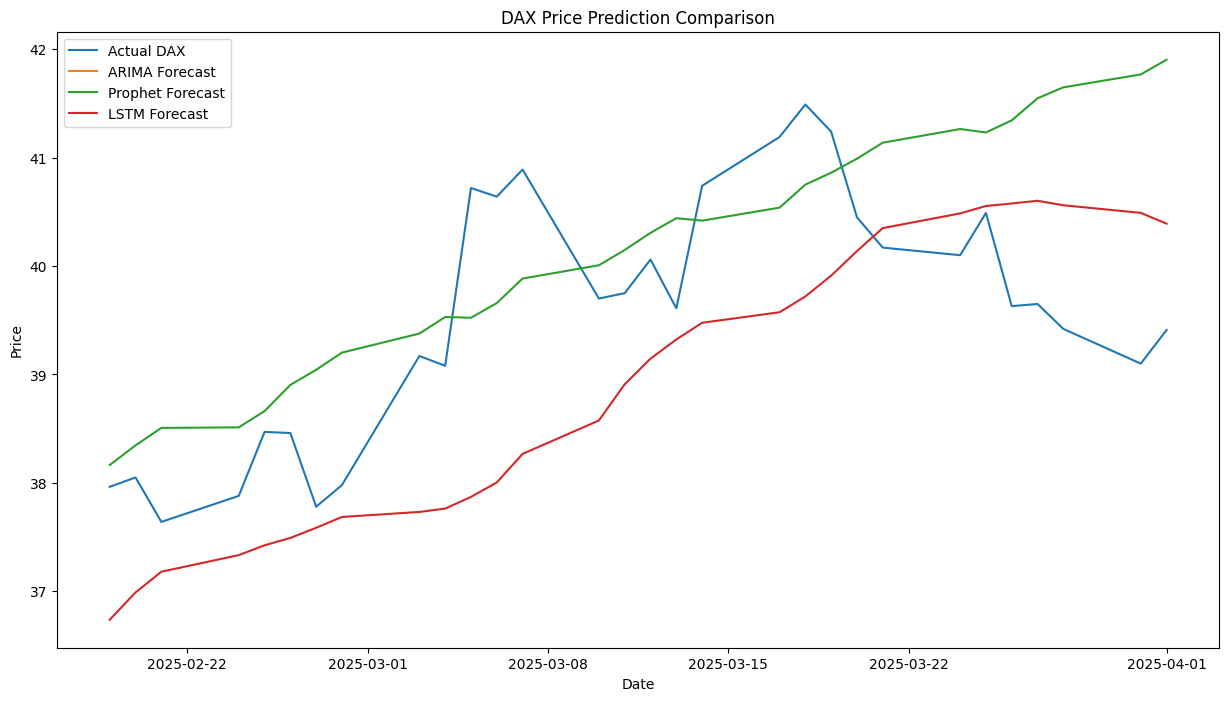

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(test['Close'], label='Actual DAX')
for model in models.keys():
    plt.plot(results[f'{model}_Pred'], label=f'{model} Forecast')

plt.title('DAX Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [110]:
from sklearn.metrics import mean_squared_error

for name, pred in models.items():
    print(f"Model:\t{name}")
    print("  RMSE:", results[f'{name}_RMSE'].mean())
    print("  MAE:", results[f'{name}_MAE'].mean())
    print()

Model:	ARIMA
  RMSE: 1.236260427372809
  MAE: 1.0619424058210312

Model:	Prophet
  RMSE: 1.1319553032488563
  MAE: 0.9081329605815858

Model:	LSTM
  RMSE: 1.2822391484867004
  MAE: 1.0718846638997401

